In [2]:
!pip install -r ../requirements.txt

  Using cached https://files.pythonhosted.org/packages/b7/ed/f47b38a48d67726862e9c1237c079150154a00bbcc60c25731f8211ad850/jupyterlab-3.2.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f1/ef/df6ce4d461fa592ae88bd271c3c944f428a2029840ae63ef3e3cd5ef4fde/numpy-1.21.3-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/b8/42/977a30bfb4ce937b188e148fcfbae913a9aa6d22ea3d32fef603444eb588/pandas-1.3.4-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/b8/e7/1ec3c8b52c4b66570fd46cb37a8b33b19c878a413f3f8726dd930291b858/matplotlib-3.4.3-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/d0/3f/176ef78770716b0fb4ae35b5f45b22a0a5e247d03d9f272fb54d3f46db8d/opencv_python-4.5.4.58-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/84/d3/5a82fe0267d33a12cc4ed07b1b1398f139d78fa20ed4e1cd61fc1f920176/pytorch_lightning-1.4.9-py3-none-any.whl
  Using cached https://file

ERROR: tensorflow 2.2.0 requires astunparse==1.6.3, which is not installed.
ERROR: tensorflow 2.2.0 requires gast==0.3.3, which is not installed.
ERROR: tensorflow 2.2.0 requires google-pasta>=0.1.8, which is not installed.
ERROR: tensorflow 2.2.0 requires h5py<2.11.0,>=2.10.0, which is not installed.
ERROR: tensorflow 2.2.0 requires scipy==1.4.1; python_version >= "3", which is not installed.
ERROR: tensorflow 2.2.0 requires termcolor>=1.1.0, which is not installed.
ERROR: sphinx 3.1.0 requires alabaster<0.8,>=0.7, which is not installed.
ERROR: sphinx 3.1.0 requires docutils>=0.12, which is not installed.
ERROR: sphinx 3.1.0 requires imagesize, which is not installed.
ERROR: scikit-learn 0.23.1 requires scipy>=0.19.1, which is not installed.
ERROR: qiskit-ignis 0.2.0 requires qiskit-terra>=0.8.0, which is not installed.
ERROR: qiskit-ignis 0.2.0 requires scipy!=0.19.1,>=0.19, which is not installed.
ERROR: qiskit-aer 0.4.1 requires cython>=0.27.1, which is not installed.
ERROR: qiski

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Scale((512, 512)),
    transforms.ToTensor()
])
unloader = transforms.ToPILImage()

C:\Users\altoz\AppData\Roaming\Python\Python37\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [6]:
def get_smallest_image(style_image: Image, content_image: Image):
    
    style_height, style_width = style_image.size
    content_height, content_width = content_image.size
    smallest_size = min(style_image.size, content_image.size)
    smallest_height, smallest_width = smallest_size
    smallest_dimension = min(smallest_height, smallest_width)
    
    return smallest_dimension

In [9]:
def prepare_images(style_image: str, content_image: str):
    style_image = Image.open(style_image)
    content_image = Image.open(content_image)
    
    image_size = get_smallest_image(style_image, content_image)
    loader = transforms.Compose([
        transforms.Scale((image_size, image_size)),
        transforms.ToTensor()
    ])  
    
    style_image = loader(style_image).unsqueeze(0)
    content_image = loader(content_image).unsqueeze(0)
    
    assert style_image.size() == content_image.size(), \
        "we need to import style and content images of the same size"
    
    return style_image.to(device, torch.float), content_image.to(device, torch.float)

In [10]:
style_img, content_img = prepare_images('../images/StarryNight.jpg', '../images/City.jpg')

In [11]:
# def image_loader(image_name):
#     image = Image.open(image_name)
#     # fake batch dimension required to fit network's input dimensions
#     image = loader(image).unsqueeze(0)
#     return image.to(device, torch.float)

# style_img = image_loader('../images/StarryNight.jpg')
# content_img = image_loader('../images/City.jpg')

# #style_img = image_loader("../images/picasso.jpg")
# #content_img = image_loader("../images/dancing.jpg")

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

# unloader = transforms.ToPILImage()  # reconvert into PIL image
# plt.ion()

In [12]:
style_img.size(), content_img.size()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [13]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

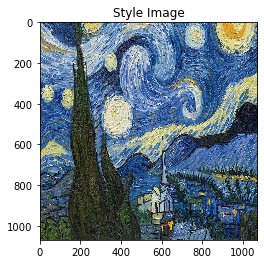

In [14]:
plt.figure()
imshow(style_img, title='Style Image')

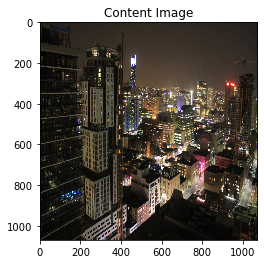

In [15]:
plt.figure()
imshow(content_img, title='Content Image')

In [16]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [18]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [19]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [20]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

######################################################################
# Additionally, VGG networks are trained on images with each channel
# normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
# We will use them to normalize the image before sending it into the network.
# 

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\altoz/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:30<00:00, 19.1MB/s]


In [22]:
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [24]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    print(model)

    return model, style_losses, content_losses

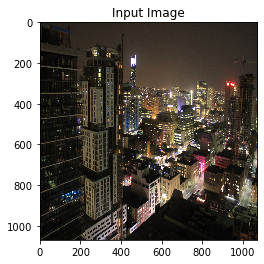

In [25]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

In [26]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [27]:
def run_style_transfer(
    cnn, 
    normalization_mean, 
    normalization_std,
    content_img,
    style_img,
    input_img,
    num_steps=300,
    style_weight=1000000,
    content_weight=1
):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn,
        normalization_mean,
        normalization_std,
        style_img,
        content_img
    )

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            out = model(input_img)
            print(f'out.shape: {out.shape}')
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), 
                        content_score.item()
                    )
                )
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [28]:
output = run_style_transfer(
    cnn, 
    cnn_normalization_mean,
    cnn_normalization_std,
    content_img,
    style_img,
    input_img
)

# plt.figure()
# imshow(output, title='Output Image')

# # sphinx_gallery_thumbnail_number = 4
# plt.ioff()
# plt.show()

Building the style transfer model..


C:\Users\altoz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
C:\Users\altoz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
Optimizing..
run [50]:
Style Loss : 114.812805 Content Loss: 26.636927

run [100]:
Style Loss : 18.524649 Content Loss: 24.936354

run 

In [42]:
output.shape

torch.Size([1, 3, 1070, 1070])

1. image.shape: torch.Size([1, 3, 1070, 1070])
2. image.shape: torch.Size([3, 1070, 1070])
3. image.shape: (1070, 1070)


NameError: name 'title' is not defined

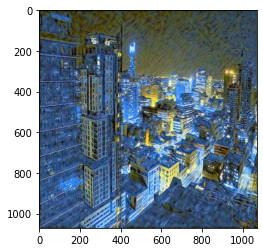

In [44]:
image = output.cpu().clone()  # we clone the tensor to not do changes on it
print(f'1. image.shape: {image.shape}')
image = image.squeeze(0)      # remove the fake batch dimension
print(f'2. image.shape: {image.shape}')
image = unloader(image)
print(f'3. image.shape: {image.size}')
plt.imshow(image)
if title is not None:
    plt.title(title)
plt.pause(0.001) # pause a bit so that plots are updated